In [1]:
import pandas as pd
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X,y = df_wine.iloc[:,1:].values, df_wine.iloc[:,0].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3, random_state=0)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)


In [16]:
# グラフ描画
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1,  X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1,  X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl , 0], y=X[y == cl, 1], alpha=0.8, c=cmap(idx), marker=markers[idx], label=cl)

In [2]:
np.set_printoptions(precision=4)
mean_vecs=[]
for label in range(1,4):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print('MV %s: %s\n' % (label, mean_vecs[label-1]))


MV 1: [ 0.9259 -0.3091  0.2592 -0.7989  0.3039  0.9608  1.0515 -0.6306  0.5354
  0.2209  0.4855  0.798   1.2017]

MV 2: [-0.8727 -0.3854 -0.4437  0.2481 -0.2409 -0.1059  0.0187 -0.0164  0.1095
 -0.8796  0.4392  0.2776 -0.7016]

MV 3: [ 0.1637  0.8929  0.3249  0.5658 -0.01   -0.9499 -1.228   0.7436 -0.7652
  0.979  -1.1698 -1.3007 -0.3912]



In [4]:
d= 13
S_W = np.zeros((d, d))
for label , mv in zip(range(1,4), mean_vecs):
    class_scatter = np.zeros((d,d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d,1), mv.reshape(d,1)
        class_scatter += (row - mv).dot((row-mv).T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))
    

Within-class scatter matrix: 13x13


In [5]:
#クラスごとに数が違う。一様ではない。
print('Class label distribution %s', np.bincount(y_train)[1:])

Class label distribution %s [40 49 35]


In [6]:
d= 13
S_W = np.zeros((d, d))
for label , mv in zip(range(1,4), mean_vecs):
    class_scatter = np.cov(X_train_std[y_train == label].T)
    S_W += class_scatter

print('Within-class scatter matrix: %sx%s' % (S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [9]:
mean_overall = np.mean(X_train_std, axis=0)
d = 13
S_B = np.zeros((d,d))
for i , mean_vec in enumerate(mean_vecs):
    n = X_train[y_train==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(d,1)
    mean_overall = mean_overall.reshape(d,1)
    S_B += n*(mean_vec - mean_overall).dot((mean_vec-mean_overall).T)

print('Between-class scatter matrix: %sx%s' % (S_B.shape[0], S_B.shape[1]))

Between-class scatter matrix: 13x13


In [11]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]

eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('Eigenvalues in decreasing order:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

Eigenvalues in decreasing order:

452.721581245
156.43636122
8.37963116479e-14
3.37938173702e-14
3.37938173702e-14
2.84217094304e-14
2.36753724288e-14
1.48487560517e-14
1.48487560517e-14
1.442402744e-14
1.442402744e-14
1.80266604142e-15
1.80266604142e-15


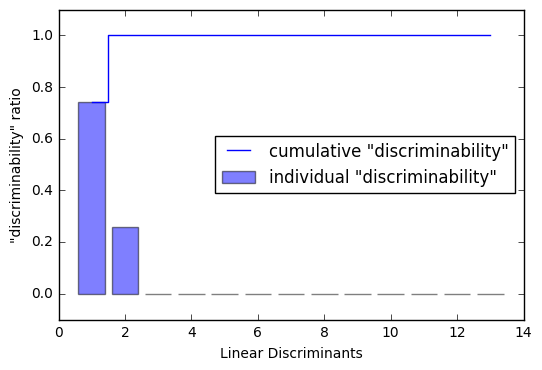

In [13]:
tot = sum(eigen_vals.real)
discr = [(i/tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

import matplotlib.pyplot as plt
plt.bar(range(1,14), discr, alpha=0.5, align='center', label='individual "discriminability"')
plt.step(range(1,14), cum_discr, where='mid', label='cumulative "discriminability"')
plt.ylabel('"discriminability" ratio')
plt.xlabel('Linear Discriminants')
plt.ylim([-0.1,1.1])
plt.legend(loc='best')
plt.show()

In [14]:
w = np.hstack((eigen_pairs[0][1][:,np.newaxis].real, eigen_pairs[1][1][:,np.newaxis].real))
print('Matrix W:\n', w)

Matrix W:
 [[-0.0662 -0.3797]
 [ 0.0386 -0.2206]
 [-0.0217 -0.3816]
 [ 0.184   0.3018]
 [-0.0034  0.0141]
 [ 0.2326  0.0234]
 [-0.7747  0.1869]
 [-0.0811  0.0696]
 [ 0.0875  0.1796]
 [ 0.185  -0.284 ]
 [-0.066   0.2349]
 [-0.3805  0.073 ]
 [-0.3285 -0.5971]]


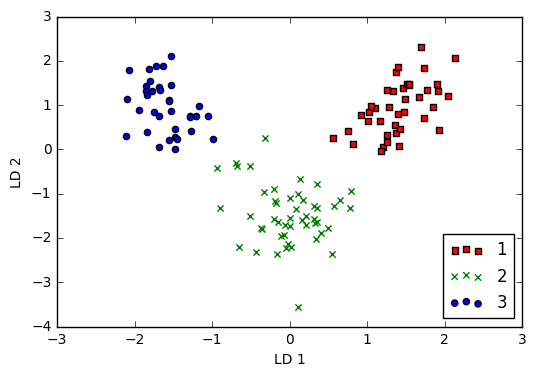

In [15]:
X_train_lda = X_train_std.dot(w)

colors=['r','g','b']
markers = ['s', 'x','o']
for l , c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_lda[y_train==l,0]*(-1), X_train_lda[y_train==l,1]*(-1), c=c, label=l,marker=m)

plt.xlabel('LD 1')
plt.ylabel('LD 2')

plt.legend(loc='lower right')
plt.show()

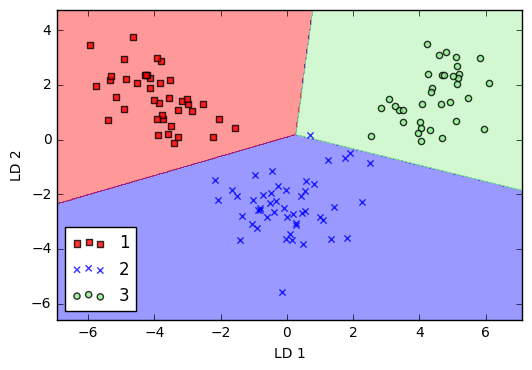

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)

#トレーニングデータの決定境界プロット
X_train_lda = lda.fit_transform(X_train_std, y_train)
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr= lr.fit(X_train_lda, y_train)

plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()

In [ ]:
#テストデータの決定境界プロット
X_test_lda = lda.transform(X_test_std)

plot_decision_regions(X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.show()